  
# TFIM Simulation Profile
1. Numerical Matrix Method : 
   This simulation uses exact matrix exponentiation for time evolution. 
   It does NOT use Trotter-Suzuki decomposition.

2. Probability Amplitudes : 
   Calculations are based on the full Statevector amplitudes. 
   No 'Sampling' or 'Shots' are involved.

3. Noise-Free Ideal Environment : 
   As a classical numerical simulation of the Schrödinger equation, 
   there is no gate error, decoherence, or readout noise.


In [ ]:
import importlib


"""

TFIM Simulation Environment Dependency Checker
Used to ensure all 'experimental apparatus' required for running physical simulations has been installed.

"""

def check_dependencies():
    # Core libraries required for the TFIM simulation
    dependencies = {
        "numpy": "Numerical computing and array handling",
        "matplotlib": "Plotting and visualization of physical evolution",
        "qiskit": "Core framework for quantum simulation",
        "scipy": "Advanced linear algebra for efficient matrix exponentiation"
    }
    
    missing_packages = []
    print("-" * 50)
    
    for lib, desc in dependencies.items():
        try:
            importlib.import_module(lib)
            print(f"✅ [INSTALLED] {lib:<12} : {desc}")
        except ImportError:
            print(f"❌ [MISSING  ] {lib:<12} : {desc}")
            missing_packages.append(lib)
    
    print("-" * 50)
    
    if not missing_packages:
        print("All systems go! You are ready to run the TFIM simulation.")
    else:
        print("⚠️ Missing components detected. Please run the following command to install them:")
        print("\n# --- Copy and execute this command in your terminal ---")
        install_cmd = f"pip install {' '.join(missing_packages)}"
        print(install_cmd)
        print("# ------------------------------------------------------\n")

if __name__ == "__main__":
    check_dependencies()

In [ ]:
#Install missing dependencies
# pip install qiskit        
# pip install numpy           
# pip install matplotlib      
# pip install scipy            


QUERY RESULT | t = 5.0
Parameters:    N=5, J=1.0, h=0.2
Initial State: |00000>
--------------------------------------------------
State (Basis)   | Probability
--------------------------------------------------
|00000>          | 0.9259
|10000>          | 0.0211
|00001>          | 0.0211
|00011>          | 0.0062
|11000>          | 0.0062
|01110>          | 0.0038
|00010>          | 0.0033
|01000>          | 0.0033
|00100>          | 0.0023
|00111>          | 0.0014

QUERY RESULT | t = 5.0
Parameters:    N=5, J=1.0, h=1.0
Initial State: |00000>
--------------------------------------------------
State (Basis)   | Probability
--------------------------------------------------
|11111>          | 0.2406
|11110>          | 0.0953
|01111>          | 0.0953
|11011>          | 0.0510
|11000>          | 0.0459
|00011>          | 0.0459
|11101>          | 0.0450
|10111>          | 0.0450
|11100>          | 0.0375
|00111>          | 0.0375

QUERY RESULT | t = 5.0
Parameters:    N=5, J=1.0, h=2.0

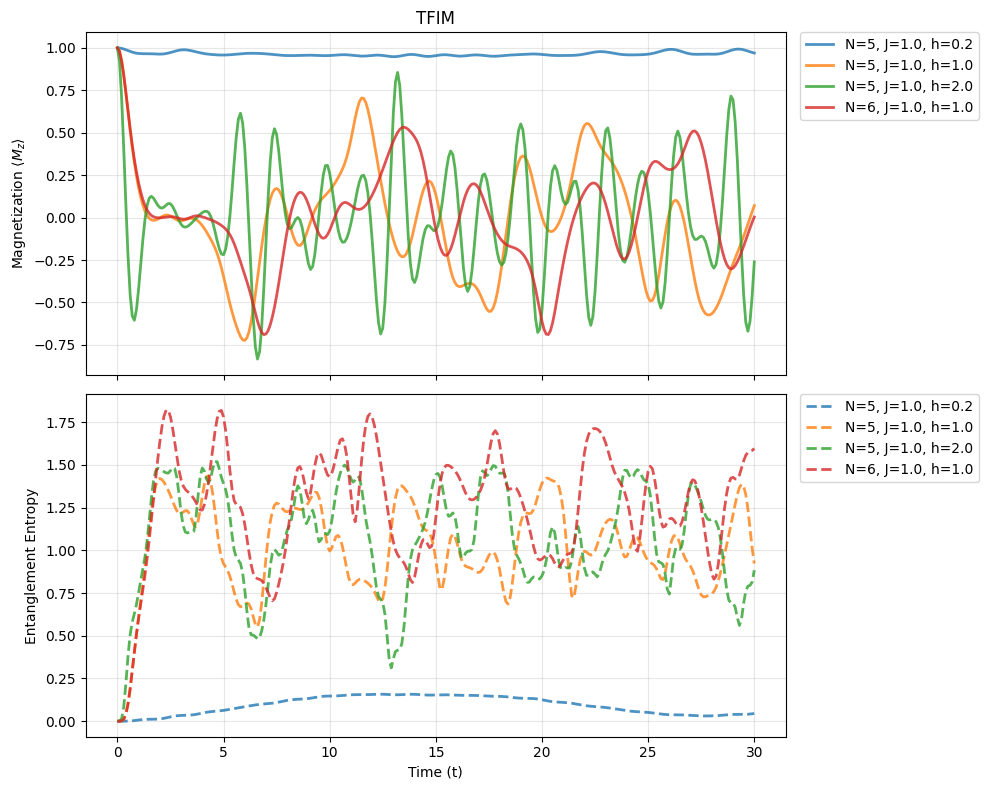

In [6]:
# Import the numpy and plot library
import numpy as np 
import matplotlib.pyplot as plt
import random

# Import the Qiskit quantum information library
from qiskit.quantum_info import (
    SparsePauliOp,  # Hamiltonian builder: Efficiently represents physical models (H) using sparse matrices.
    Statevector,    # Quantum state container: Stores the wave function |ψ(t)⟩ and tracks its evolution.
    partial_trace,  # Subsystem partitioning: Traces out unwanted qubits to compute reduced density matrices.
    entropy,        # Entanglement measure: Calculates Von Neumann entropy to quantify quantum correlations.
    Operator        # Matrix converter: Transforms abstract quantum gates into concrete mathematical matrices for simulation.
)

# Import the time evolution library
## Time evolution engine: Computes the unitary operator U(t) = exp(-i*H*t) for a given Hamiltonian.
from qiskit.circuit.library import PauliEvolutionGate  


# ==========================================
# System Parameters
# ==========================================
# Format: [N (Qubits), J (Interaction), h (Field), "Initial State"]
#The number of qubits should be around 2~10
#Initial State Options:
# - "000..." : Z-axis Up (|0>) "111..." dwon (|1>)
# - "+++..."    : X-axis Plus (Aligned with transverse field)
# - "r"      : Random bitstring (Stochastic initialization)

param_groups = [
    [5, 1.0, 0.2, "00000"],   # Ferromagnetic phase (Ordered, h < J)
    [5, 1.0, 1.0, "00000"],   # Critical point (Phase transition, h = J)
    [5, 1.0, 2.0, "00000"],   # Paramagnetic phase (Disordered, h > J)
    [6, 1.0, 1.0, "000000"],   # Finite-size scaling comparison (N=5 VS N=6)
    
    #[N , J, H, "..."]
]

# Time Evolution Settings
t_max = 30          # Total duration of the simulation 
steps = 300         # Time steps
dt = t_max / steps  # Time interval per step 
query_t = 5         # Specific timestamp to inspect the wavefunction details

PROB_THRESHOLD = 0.001  #Probability Cutoff Threshold 

# ==========================================
# Simulation Core Logic
# ==========================================
def simulate_tfim(N, J, h, Initial_state_input):
    """
    Simulates the time evolution of the TFIM model.
    """
    # Handle Randomized Initialization 
    if Initial_state_input.lower() == "r":
        # Generate a stochastic 0/1 bitstring of length N
        current_initial_state = "".join(random.choice("01") for _ in range(N))
    else:
        current_initial_state = Initial_state_input
    
    # Adaptive Length  and Correction 
    # Ensures the initial state string aligns with the number of qubits N
    current_len = len(current_initial_state)
    if current_len < N:
        # Auto-fill based on basis: '+' for X-basis, '0' for Z-basis
        fill_char = "+" if "+" in current_initial_state else "0"
        current_initial_state = current_initial_state + fill_char * (N - current_len)
    elif current_len > N:
        # Truncate if input string exceeds system size
        current_initial_state = current_initial_state[:N]

    # Hamiltonian Construction 
    # Adjacent interaction terms (-J * Zi * Zj)
    interaction = [("ZZ", [i, i+1], -J) for i in range(N-1)]
    # Transverse magnetic field terms (-h * Xi)
    field = [("X", [i], -h) for i in range(N)]
    H = SparsePauliOp.from_sparse_list(interaction + field, num_qubits=N)
    
    # Time Evolution Propagator 
    # Pre-calculating the unitary matrix U(dt) = exp(-i*H*dt) for iteration
    U_step = Operator(PauliEvolutionGate(H, time=dt))
    
    # Prepare the initial statevector 
    psi = Statevector.from_label(current_initial_state)
    
    # Mz operator defined as the average longitudinal magnetization: (1/N) * Σ Zi
    Mz_op = SparsePauliOp.from_sparse_list([("Z", [i], 1/N) for i in range(N)], num_qubits=N)
    
    # Initialize containers 
    times_list, mz_list, ent_list = [], [], []
    
    # Main Evolution Loop 
    for step in range(steps + 1):
        t = step * dt
        times_list.append(t)
        
        # Calculate and store the magnetization at each time point
        mz_list.append(psi.expectation_value(Mz_op).real)
        
        # Compute the von Neumann entropy of the half-chain.
        # Compute entanglement entropy between two partitions.
        # range(N // 2, N) defines the qubits to be "traced out" (ignored).
        # Here, partition the chain into two halves: [0 to N/2-1] and [N/2 to N-1].
        ent_list.append(entropy(partial_trace(psi, range(N // 2, N)))) 
        
        # This can be customized
        # Example: Entanglement between only the 0th bit and all remaining bits
        # partial_trace(psi, range(1, N)
        
        # Printing Probability Distributions at query_t 
        if np.isclose(t, query_t, atol=dt/2):
            print(f"\n" + "="*50)
            print(f"QUERY RESULT | t = {t:.1f}")
            print(f"Parameters:    N={N}, J={J}, h={h}")
            print(f"Initial State: |{current_initial_state}>")
            print("-" * 50)
            print(f"{'State (Basis)':<15} | {'Probability':<10}") 
            print("-" * 50)
            
            # Determine the probability of each quantum state
            probs = psi.probabilities_dict()
            # Sort in descending order of probability
            top_states = sorted(probs.items(), key=lambda x: x[1], reverse=True) 
            
            #Output the ten largest quantum state probabilities
            #and remove quantum states with probabilities below the threshold
            count = 0
            for s, p in top_states[:10]:  
                if p > PROB_THRESHOLD:
                    print(f"|{s}>{' ':<9} | {p:.4f}")
                    count += 1
             
            if count == 0:
                print(f"(No state exceeds PROB_THRESHOLD={PROB_THRESHOLD})")
            print("="*50)
            
        # Evolve the state to the next time step 
        if step < steps:
            psi = psi.evolve(U_step)
            
    return times_list, mz_list, ent_list

# ==========================================
# plot figure
# ==========================================
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

for params in param_groups:
    n_val, j_val, h_val, init_str = params #Unpack the system-set parameters
    
    t, mz, ent = simulate_tfim(n_val, j_val, h_val, init_str) # Run simulation
    
    # Add the label
    label_str = f"N={n_val}, J={j_val}, h={h_val}"
    
    #Plotting the magnetization along the Z-axis
    ax1.plot(t, mz, label=label_str, linewidth=2, alpha=0.8)
    #Plotting the entanglement entropy
    ax2.plot(t, ent, label=label_str, linewidth=2, alpha=0.8, linestyle='--')

ax1.set_ylabel(r'Magnetization $\langle M_z \rangle$')
ax1.set_title(f'TFIM')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.) 
ax1.grid(True, alpha=0.3)

ax2.set_ylabel('Entanglement Entropy')
ax2.set_xlabel('Time (t)')
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()